In [64]:
import numpy as np
from netCDF4 import Dataset
from py_wake.site.shear import PowerShear
import xarray as xr
import netCDF4
from datetime import datetime
import matplotlib.pyplot as plt
from py_wake.site import UniformSite
from py_wake.examples.data.iea37 import IEA37_WindTurbines
from py_wake.site import XRSite

In [65]:
nc_data = Dataset("wnd10m.gdas.201011.nc")
print(nc_data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: COARDS
    History: created by wgrib2
    GRIB2_grid_template: 40
    dimensions(sizes): latitude(576), longitude(1152), time(720)
    variables(dimensions): float64 latitude(latitude), float64 longitude(longitude), float64 time(time), float32 UGRD_10maboveground(time, latitude, longitude), float32 VGRD_10maboveground(time, latitude, longitude)
    groups: 


In [66]:
# Extract wind speed and direction from the NetCDF variables
time = nc_data.variables['time'][:]
U_p1= nc_data.variables['UGRD_10maboveground'][:,367,387]
V_p1= nc_data.variables['VGRD_10maboveground'][:,367,387]
x_location=nc_data.variables['longitude'][387]*111
y_location=nc_data.variables['latitude'][367]*111
# Close the NetCDF file
nc_data.close()
speed_p1=np.sqrt(np.square(U_p1) + np.square(V_p1))
Dir_p1= np.degrees(np.arctan2(-V_p1,-U_p1)) ##Wind speed direction & wind direction are opposite
Dir_p1=np.where(Dir_p1<0,Dir_p1+360,Dir_p1)
np.savez('siteData.npz', arr1=time,arr2=speed_p1,arr3=Dir_p1)

In [74]:
# Load multiple arrays
Site_data = np.load('siteData.npz')
ws=Site_data['arr2']
wd=Site_data['arr3']

Define XRsite

In [75]:
# Define bins for wind speed and direction
wind_speed_bins = np.linspace(0, 30.5, 61, endpoint=False)  # Bins from 0 to 30 m/s
wind_direction_bins = np.linspace(0, 370,37,endpoint=False)  # Bins every 10 degrees
print(wind_direction_bins)
# Digitize the wind data into these bins
ws_indices = np.digitize(speed_p1, wind_speed_bins)
wd_indices = np.digitize(Dir_p1, wind_direction_bins)

# Create a 2D histogram to count occurrences
hist, ws_edges, wd_edges = np.histogram2d(speed_p1, Dir_p1, bins=[wind_speed_bins, wind_direction_bins])
# Normalize the histogram to get probabilities
probabilities = hist / hist.sum()
print(np.shape(probabilities))
# Create xarray DataArray for probabilities
#P = xr.DataArray(probabilities, coords=[('ws', wind_speed_bins[:]), ('wd', wind_direction_bins[:])])

# Define turbulence intensity (TI)
ti = 0.1

# Create the dataset for XRSite
site_ds = xr.Dataset(
    data_vars={
        'P': (('wd', 'ws'), probabilities.T),
     #   'TI': (('ws', 'wd'), np.full(probabilities.shape, ti))
    },
    coords={
        'ws': wind_speed_bins[:-1],
        'wd': wind_direction_bins[:-1]
    }
)

site = XRSite(
    ds=site_ds,
   # shear=PowerShear(h_ref=10, alpha=0.2)
)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360.]
(60, 36)


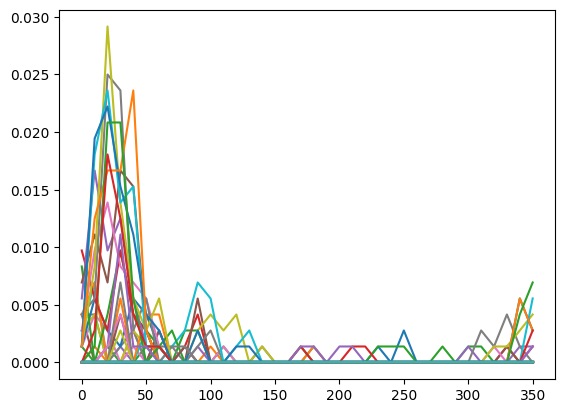

In [76]:
plt.plot(wind_direction_bins[:-1], probabilities.T)

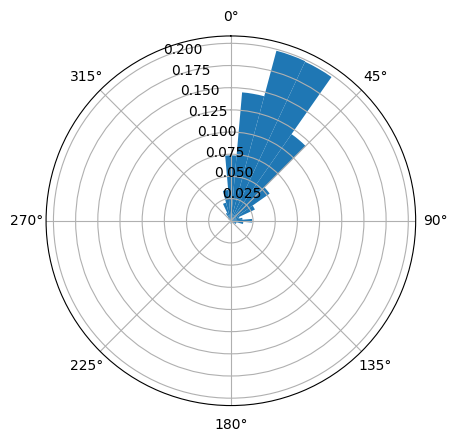

In [89]:
_ = site.plot_wd_distribution(n_wd=36)#ws_bins=wind_speed_bins[:-1])

ValueError: Cannot interpolate ws-dependent P to other range of ws

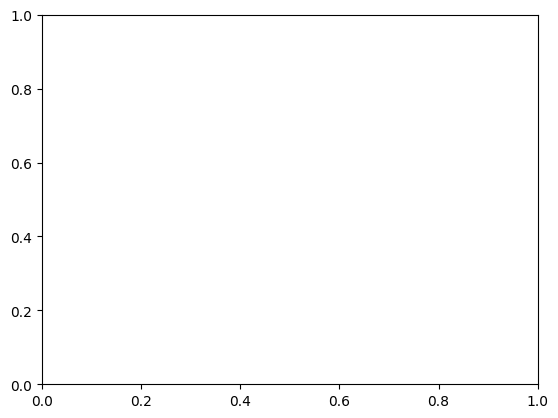

In [81]:
_ = site.plot_ws_distribution()